# Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! cp -r drive/My\ Drive/ml_projects/kaggle/google_quest/google-quest-challenge .

In [0]:
! cp drive/My\ Drive/ml_projects/ml_datasets/nlp_pretrained/Glove/glove.6B.50d.txt .

# Resume

In [0]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.run_this_cell {display: block !important;} </style"))

In [7]:
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, concatenate, LSTM, Bidirectional, Embedding, add, Dense
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

from tensorflow.keras import models, layers, optimizers


from datetime import datetime
from typing import List, Dict, Tuple, Any

from collections import Counter
# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm, tqdm_notebook, tnrange
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()

In [9]:
tf.__version__

'2.1.0-rc1'

In [0]:
%matplotlib inline

In [0]:
"""
Because of the following error
```

OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. 
That is dangerous, since it can degrade performance or cause incorrect results. 
The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, 
e.g. by avoiding static linking of the OpenMP runtime in any library. 
As an unsafe, unsupported, undocumented workaround you can set the environment variable 
KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, 
but that may cause crashes or silently produce incorrect results. 
For more information, please see http://www.intel.com/software/products/support/.


"""


import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'



# Ideas to try

1. Regularize the parameters, try a bigger Glove Embedding, try a different embedding?
2. Split into test and train sets
3. Understand the evaluation metric very well and see if you can obtain that value for the validation set - Is MSE a good loss to optimize?
4. Understand RMSProp very well and see what are the tradeoffs? 
5. Do you need to perform LR schedule? - https://www.kaggle.com/buntyshah/google-quest-q-a-labeling-embeddings-glove?scriptVersionId=25754126#Model this guy has it.
6. Do not attempt transformers until you have exhausted all of LSTM based methods.

# Utility Functions

In [0]:
def clean_text(x):

    x = str(x)
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^`{|}~' + '“”’':
        x = x.replace(punct, f' {punct}')
   
    for punct in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—_':
        x = x.replace(punct, f' {punct}')
 
    return x

In [0]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

In [0]:
mispell_dict = {"usepackage" : "use package",
                'instrumentsettingsid':'instrumental settings id',
                'RippleShaderProgram' : 'ripple shader program',
                'ShaderProgramConstants':'shader program constants',
                'storedElements':'stored elements',
                'stackSize' : 'stack size',
                '_':' '

                }

In [0]:
mispellings, mispellings_re = _get_mispell(mispell_dict)

In [0]:
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

## Spearmans Correlation

In [0]:
from scipy.stats import spearmanr
import math

def calculate_mean_spearman_co(a, b):
    """
        Calculates spearmans correlation coefficient 
        https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
        
        In the scipy implementation if you pass x and y and if one of them is composed of all same values,
        then it returns nan. I am changing those nans to zeros
    """
    print(a.shape, b.shape, len(a.shape))
    print(a, b)
    if len(a.shape) == 1:
        return 0

    if a.shape[0] is None and a.shape[1] is None:
         return 0
         
    ans = [spearmanr(a[:, i], b[:, i])[0] for i in range(a.shape[1])]

    ans = [0. if math.isnan(elem) else elem for elem in ans]
    return np.mean(ans), ans

# Loading the data

In [0]:
# train_loc = '/kaggle/input/google-quest-challenge/train.csv'
# test_loc= '/kaggle/input/google-quest-challenge/test.csv'

train_loc = 'google-quest-challenge/train.csv'
test_loc= 'google-quest-challenge/test.csv'

train_df = pd.read_csv(train_loc)
test_df = pd.read_csv(test_loc)


In [0]:
len(train_df), len(test_df)

(6079, 476)

# Preprocessing

In [0]:
train_df["question_body"] = train_df["question_body"].apply(clean_text)
train_df["question_body"] = train_df["question_body"].apply(replace_typical_misspell)

train_df["question_title"] = train_df["question_title"].apply(clean_text)
train_df["question_title"] = train_df["question_title"].apply(replace_typical_misspell)

train_df["category"] = train_df["category"].apply(clean_text)
train_df["category"] = train_df["category"].apply(replace_typical_misspell)

train_df["answer"] = train_df["answer"].apply(clean_text)
train_df["answer"] = train_df["answer"].apply(replace_typical_misspell)


test_df["question_body"] = test_df["question_body"].apply(clean_text)
test_df["question_body"] = test_df["question_body"].apply(replace_typical_misspell)

test_df["question_title"] = test_df["question_title"].apply(clean_text)
test_df["question_title"] = test_df["question_title"].apply(replace_typical_misspell)

test_df["category"] = test_df["category"].apply(clean_text)
test_df["category"] = test_df["category"].apply(replace_typical_misspell)

test_df["answer"] = test_df["answer"].apply(clean_text)
test_df["answer"] = test_df["answer"].apply(replace_typical_misspell)

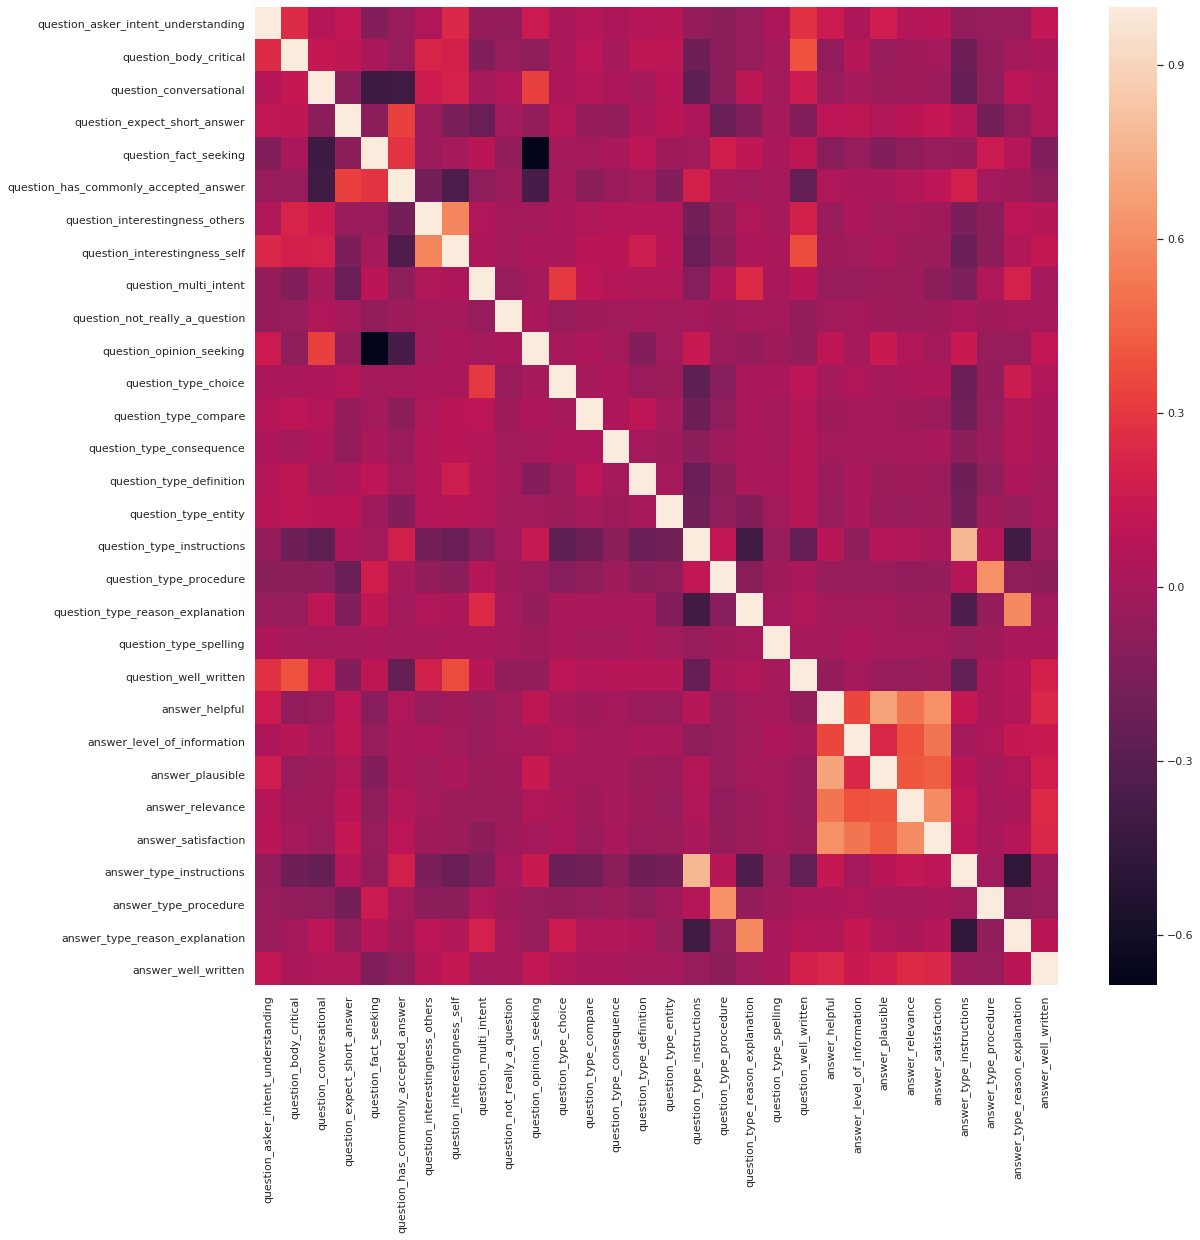

In [0]:
TARGET_COLUMN_NAMES = ['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
fig, ax = plt.subplots(figsize=(18, 18))

sns.heatmap(train_df[TARGET_COLUMN_NAMES].corr(), ax=ax)

# Model starts

## Building Vocabulary

In [0]:
def build_vocabulary(instances: List[Dict],
                     vocab_size: 10000,
                     text_column_names: List[str]) -> Tuple[Dict, Dict]:
    """
    Given the instances and max vocab size, this function builds the
    token to index and index to token vocabularies. If list of add_tokens are
    passed, those words will be added first.
    Parameters
    ----------
    instances : ``List[Dict]``
        List of instance returned by read_instances from which we want
        to build the vocabulary.
    vocab_size : ``int``
        Maximum size of vocabulary
    text_column_names : ``List[str]``
        These are the column names (key names) of the required text fields.
     """
    print("\nBuilding Vocabulary.")

    # make sure pad_token is on index 0
    UNK_TOKEN = "@UNK@"
    PAD_TOKEN = "@PAD@"
    UNK_POS = "@POS@"
    token_to_id = {PAD_TOKEN: 0, UNK_TOKEN: 1, UNK_POS: 2}

    # Add remaining tokens from the instances as the space permits
    words = []
    for instance in all_train_data:
        [words.extend(instance[key].split()) for key in text_column_names]
        for key in text_column_names:
            words.extend(instance[key].split())
            
    token_counts = dict(Counter(words).most_common(vocab_size))
    for token, _ in token_counts.items():
        if token not in token_to_id:
            token_to_id[token] = len(token_to_id)
        if len(token_to_id) == vocab_size:
            break

    # add pos tags to vocab
#     for tag in util.TAG_MAP:
#         if tag not in token_to_id:
#             token_to_id[tag] = len(token_to_id)
#         if len(token_to_id) == vocab_size:
#             break

    # Make reverse vocabulary lookup
    id_to_token = dict(zip(token_to_id.values(), token_to_id.keys()))
    return (token_to_id, id_to_token)

In [0]:
def convert_to_ids(instances: List[Dict], 
                   vocab_token_to_id: Dict[str, int],
                   text_column_names: List[str]) -> List[Dict]:
    """
        For a given training instance, it returns the tokenized version of its text contents
        OUTPUT: in the key 'all', you find the token_ids for the concatenated question_text, question_body etc
    """
    
    for instance in instances:
        total = []
        
        for key in text_column_names:
            sentence = instance[key]
            ids = []
            for token in sentence.split():
                if token in vocab_token_to_id:
                    ids.append(vocab_token_to_id[token])
                else:
                    ids.append(vocab_token_to_id['@UNK@'])
            
            new_key = key+'_id'
            
            instance[new_key] = ids
            
            total.extend(ids)
        
        instance['all'] = total

            
    return instances

In [0]:
def generate_batches(instances: List[Dict],
                     bsz: int,
                     text_column_names: List[str],
                     target_column_names: List[str],
                     training: bool=True) -> List[Dict[str, np.ndarray]]:
    """
        Crates batches of tensor inputs that can be directly fed to the model
    """
    result = []
    max_token_lengths = 6300
    for index in tqdm(range(0, len(instances), bsz)):
        batch = instances[index: index + bsz]
        
        # token_lengths = [len(b['all']) for b in batch]
        # max_token_lengths = max(token_lengths)
        
        num_elements_in_batch = min(len(batch), bsz)
        
        if training:
            real_batch = {
                'X': np.zeros((num_elements_in_batch, max_token_lengths), dtype=np.int32), 
                'Y': np.zeros((num_elements_in_batch, len(target_column_names)), dtype=np.float64)
            }
        else:
            real_batch = {
                'X': np.zeros((num_elements_in_batch, max_token_lengths), dtype=np.int32)
            }
        
        for idx, elem in enumerate(batch):
            inputs = np.array(elem['all'])
            token_len = len(inputs)
            real_batch['X'][idx][:token_len] = inputs
            if training:
                outputs = np.array([elem[k] for k in target_column_names] )
                real_batch['Y'][idx] = outputs
                
        result.append(real_batch)
        
    return result

In [0]:
all_train_data = train_df.to_dict('records')
all_test_data = test_df.to_dict('records')

In [0]:
all_data = all_train_data + all_test_data
print(f'length of all train data :: {len(all_data)}, len of train data:: {len(all_train_data)}, len of test data:: {len(all_test_data)}')

length of all train data :: 6555, len of train data:: 6079, len of test data:: 476


In [0]:
VOCAB_SIZE = 100000
BSZ = 128
TEXT_COLUMN_NAMES = ['question_title', 'question_body', 'answer', 'category']
TARGET_COLUMN_NAMES = ['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']

In [0]:
vocab_token_to_id, vocab_id_to_token = build_vocabulary(all_data, VOCAB_SIZE, TEXT_COLUMN_NAMES, )


Building Vocabulary.


In [0]:
all_data = convert_to_ids(all_data, vocab_token_to_id, TEXT_COLUMN_NAMES)

In [0]:
idx = len(all_train_data)
train_data = all_data[:idx]
test_data = all_data[idx:]

In [0]:
train_batches = generate_batches(train_data, BSZ, TEXT_COLUMN_NAMES, TARGET_COLUMN_NAMES)

100%|██████████| 48/48 [00:00<00:00, 175.70it/s]


## Loading Glove Embeddings

In [0]:
def load_embedding_matrix(embedding_loc: str, 
                          embedding_dim: int, 
                          vocab_id_to_token: Dict[int, str]) -> np.ndarray:
    embeddings = {}
    vocab_size = len(vocab_id_to_token)
    
    print(f'Reading embedding dimension info from {embedding_loc}')
    with open(embedding_loc) as file:
        for i, line in enumerate(tqdm(file)):
            token = line.split(' ', 1)[0]
            vecs = fields = line.rstrip().split(' ')
            vector = np.asarray(vecs[1:], dtype='float32')
            embeddings[token] = vector
            
        
    print(f'Creating Embedding Matrix')
    
    all_embeddings = np.asarray(list(embeddings.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_std = float(np.std(all_embeddings))
    
    # I think this is done so that for unk tokens we have the mean and std
    # as the default representation
    embedding_matrix = np.random.normal(embeddings_mean, embeddings_std,
                                        (vocab_size, embedding_dim))
    
    for idx, token in vocab_id_to_token.items():
        if token in embeddings:
            embedding_matrix[idx] = embeddings[token]
            
    return embedding_matrix

In [0]:
GLOVE_LOC = 'glove.6B.50d.txt'
# GLOVE_LOC = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'

EMBEDDING_DIM = 50

embedding_matrix = load_embedding_matrix(GLOVE_LOC, EMBEDDING_DIM, vocab_id_to_token)

6574it [00:00, 65738.81it/s]

Reading embedding dimension info from glove.6B.50d.txt


400000it [00:05, 72996.17it/s]


Creating Embedding Matrix


## Building the Model

In [0]:
LSTM_UNITS = 64
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

In [0]:
class MyModel(models.Model):
    def __init__(self, embedding_dim, vocab_size):
        super(MyModel, self).__init__()
        
        hidden_size = LSTM_UNITS
        
        self.embeddings = tf.Variable(tf.random.normal((vocab_size, embedding_dim)))
        
        model = models.Sequential()
        forward_layer = layers.LSTM(hidden_size, return_sequences=True)
        backward_layer = layers.LSTM(hidden_size, return_sequences=True, go_backwards=True)
        model.add(layers.Bidirectional(forward_layer, backward_layer=backward_layer))
        
        self.model = model
        self.d1 = Dense(DENSE_HIDDEN_UNITS, activation='relu')
        self.d2 = Dense(DENSE_HIDDEN_UNITS, activation='relu')
        self.d3 = Dense(30, activation='sigmoid')
        
        
    def call(self, inputs, training):
        word_embeds = tf.nn.embedding_lookup(self.embeddings, inputs)
#         print('word_embeds.shape', word_embeds.shape)
        # tokens_mask = tf.convert_to_tensor(inputs!=0, dtype=tf.bool)
        # print('inputs.shape', inputs.shape, inputs.dtype)
        tokens_mask = inputs != 0
        # print("tokens_mask", tokens_mask)
        
        x = self.model(word_embeds, mask=tokens_mask) #[bsz x tokens x 128]
        #concat([ [bsz x 128], [bsz x  128] ])
        hidden = layers.concatenate([GlobalMaxPooling1D()(x), GlobalAveragePooling1D()(x)])
        
        # Skip connections here
        hidden = layers.add([hidden, self.d1(hidden)])
        hidden = layers.add([hidden, self.d2(hidden)])
        
        hidden = self.d3(hidden)
#         print('x.shape', x.shape)
#         print('hidden.shape', hidden.shape)
        return hidden


In [0]:
optimizer = optimizers.RMSprop()

In [0]:
model = MyModel(EMBEDDING_DIM, VOCAB_SIZE)
model.embeddings = tf.convert_to_tensor(embedding_matrix, dtype=tf.float32)

In [0]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [0]:
# for i in tnrange(10, desc='1st loop'):
#     for j in tqdm_notebook(range(100), desc='2nd loop'):
#         time.sleep(0.01)

In [0]:
n_epochs = 10
for epoch in tqdm_notebook(range(n_epochs), desc='Epoch'):
    total_loss = 0
    total_spearman = []
    for index, batch in tqdm_notebook(enumerate(train_batches)):
        with tf.GradientTape() as tape:
            output = model(batch['X'], True) # [10 x 30]
            loss = tf.keras.losses.MSE(batch['Y'], output) #[10,]
            _, spearman = calculate_mean_spearman_co(batch['Y'], output)
            loss = tf.reduce_mean(loss)    
        grads = tape.gradient(loss, model.trainable_variables)

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        total_loss += loss
        total_spearman += spearman
#         print(f'{index}, loss: {loss}, {len(total_spearman)}, {len(spearman)}, {total_loss}')
        
    print(f'Epoch {epoch} - loss: {total_loss/len(train_batches)}, -spearman: {np.mean(spearman)}')
    # break

Epoch 0 - loss: 0.06325102597475052, -spearman: 0.20654752534050055


Epoch 1 - loss: 0.055191513150930405, -spearman: 0.26526075808875077


Epoch 2 - loss: 0.05325987935066223, -spearman: 0.2875819955533728


Epoch 3 - loss: 0.051716387271881104, -spearman: 0.29566735009459644


Epoch 4 - loss: 0.05076584219932556, -spearman: 0.301845956329067


Epoch 5 - loss: 0.04997800290584564, -spearman: 0.3060626362964134


Epoch 6 - loss: 0.04924881458282471, -spearman: 0.33527889229887436


Epoch 7 - loss: 0.04816919192671776, -spearman: 0.3392803268048414


Epoch 8 - loss: 0.04761625826358795, -spearman: 0.3368770818915327


Epoch 9 - loss: 0.04678788408637047, -spearman: 0.35002203589561104


## Evaluation

In [0]:
class ModelTest(models.Model):
    def __init__(self):
        super(ModelTest, self).__init__()
        self.emb = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)

    def call(self, inputs):
        out = self.emb(inputs)
        return out

In [0]:
m = ModelTest()

In [0]:
out = m(train_batches[0]['X'])

In [0]:
out.shape, train_batches[0]['X'].shape

(TensorShape([128, 6300, 50]), (128, 6300))

In [0]:
e = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)

In [0]:
words = Input(shape=(None, ))
x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)

hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])

hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])

In [0]:
result = Dense(30, activation='sigmoid')(hidden)

In [0]:
model = Model(inputs=words, outputs=[result])
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae'])

In [0]:
# model.summary()

In [0]:
len(train_batches[0]['X'])

128

In [0]:
train_x = [train_batches[i]['X'] for i in range(len(train_batches))]
train_y = [train_batches[i]['Y'] for i in range(len(train_batches))]

In [0]:
train_x = concatenate(train_x , axis=0 )
train_y = concatenate(train_y , axis=0 )

print(train_x.shape, train_y.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(6079, 6300) (6079, 30)


In [0]:
model.fit(
           train_x, train_y,
            batch_size=128,
            epochs=10,
            verbose=1,
        )

Train on 6079 samples
Epoch 1/10
6079/6079 [==============================] - 57s 9ms/sample - loss: 0.0591 - mae: 0.1694
Epoch 2/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0558 - mae: 0.1625
Epoch 3/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0534 - mae: 0.1576
Epoch 4/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0520 - mae: 0.1547
Epoch 5/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0511 - mae: 0.1530
Epoch 6/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0497 - mae: 0.1507
Epoch 7/10
6079/6079 [==============================] - 56s 9ms/sample - loss: 0.0485 - mae: 0.1484
Epoch 8/10
6079/6079 [==============================] - 56s 9ms/sample - loss: 0.0475 - mae: 0.1463
Epoch 9/10
6079/6079 [==============================] - 55s 9ms/sample - loss: 0.0465 - mae: 0.1447
Epoch 10/10
6079/6079 [==============================] - 55s 9ms/sample - loss

# Predictions

In [0]:
loc = "google-quest-challenge/sample_submission.csv"
# loc = "/kaggle/input/google-quest-challenge/sample_submission.csv"

sub = pd.read_csv(loc)

In [0]:
BSZ = len(test_data)
test_batches = generate_batches(test_data, BSZ, TEXT_COLUMN_NAMES, TARGET_COLUMN_NAMES, training=False)

100%|██████████| 1/1 [00:00<00:00, 53.34it/s]


In [0]:
test_x = test_batches[0]['X']
# test_y = [test_batches[i]['Y'] for i in range(len(test_batches))]

test_x.dtype, test_x.shape, type(test_x)
# test_x = concatenate(test_x , axis=0 )
# test_y = concatenate(test_y , axis=0 )

(dtype('int32'), (476, 6300), numpy.ndarray)

In [0]:
predictions = model(test_x, False)

In [0]:
predictions.shape

TensorShape([476, 30])

In [0]:
for col_index, col in enumerate(TARGET_COLUMN_NAMES):
    sub[col] = predictions[:, col_index]

In [0]:
name = 'submission.csv'
sub.to_csv(name, index = False)